# TRAINING OF BETTER NN - HARD

In [1]:
# imports
import atc_dataloader, atc_model
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from atc_loss import PredictionLoss_COS_MSE, PredictionLoss_BOX_Wise
import time

In [2]:
# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def transform_vector_to_integers(pred):
    # //////////////////////////////////////////////////////////
    # CURRENTLY NOT USED
    # //////////////////////////////////////////////////////////
    # get the max value, that will serve as reference - where is the max, there is supposed to be 1 (or other integer, depends...)
    # for now, everything until 1.3 will be treated as 1, until 2.3 as two etc.
    
    # lambda to round function from the specific treshold defined in range [.0;1.0)
    my_treshold = 0.3
    tr = np.min([my_treshold, pred.max()*0.9])

    myround = np.vectorize(lambda x, treshold=tr: np.floor(x) if x < (np.floor(x) + treshold) else np.ceil(x))

    result = np.apply_along_axis(func1d=myround, axis=0,arr=pred)
    return result

def evaluate(model, data_loader, device, criterion):
    """
    function used to evaluate the model, return loss and accuracy
    """
    model.eval()
    
    test_loss = []
    with torch.no_grad():
        for  _, batch_in_vectors, batch_out_vectors in data_loader:
            pred = model(batch_in_vectors.to(device))
            loss = criterion(pred, batch_out_vectors.to(device))
            test_loss.append(loss.item())
    
    return np.mean(test_loss)

# def evaluate_real_similarity(dl_test,model,device):
    

In [4]:
def train_model(model, device, train_dl, test_dl, criterion, optimizer, epochs=10, save_model_last_epoch=True, model_path='.'):
    
    # loss that will be calculated after each epoch for both test and train set 
    train_loss_overall = []
    test_loss_overall = [] 
    
    for epoch in range(epochs):
        epoch_loss = []
        model.train()  # Set the model to training mode
        
        # Wrap dataloader with tqdm for progress visualization
        for _, batch_in_vectors, batch_out_vectors in tqdm(train_dl, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
            # Convert data to tensors and move to the correct device
            batch_in_vectors = torch.tensor(batch_in_vectors, dtype=torch.float32, requires_grad=True).to(device)
            batch_out_vectors = torch.tensor(batch_out_vectors, dtype=torch.float32).to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_in_vectors)
            
            # Calculate loss
            loss = criterion(outputs, batch_out_vectors)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            epoch_loss.append(loss.item())

        if (epoch % 10 == 0):
            torch.save(model.state_dict(), f'models/model_betternnhard_epoch_{epoch}.pth')
        
        # start evaluation and append test loss
        tmp_test_loss = evaluate(model, test_dl, device, criterion)
        test_loss_overall.append(tmp_test_loss)
        
        # Calculate average train loss for the epoch
        avg_train_loss = np.mean(epoch_loss)
        train_loss_overall.append(avg_train_loss) # add it to the loss over all epochs
        
        # Print loss (both train and test) for the current epoch
        print(f"Epoch [{epoch+1}/{epochs}], Train loss: {avg_train_loss:.4f}, Test loss: {tmp_test_loss:.4f}")

    # ====================================
    # AFTER TRAIN ========================
    # ====================================
    
    # save the model after the last epoch if set
    # if (save_model_last_epoch):
    #     torch.save(model.state_dict(), f'{model_path}/model_last_epoch_{time.time_ns()}.pth')
        
    # print overall loss
    print('Overall train loss: ', train_loss_overall)
    print('Overall test loss: ', test_loss_overall)
    # plot graph
    plt.figure()
    plt.plot(np.arange(0,epochs,1),train_loss_overall, label='Train loss') # train loss over all epochs
    plt.plot(np.arange(0,epochs,1),test_loss_overall, label='Test loss') # test loss over all epochs
    plt.title('Loss function')
    plt.show()
    
    return train_loss_overall, test_loss_overall

In [12]:
class BetterNN_hard(nn.Module):
    """
    This is a better neural network model ready to use feature vector
    """
    def __init__(self, input_size=40, output_size=18):
        super(BetterNN_hard, self).__init__()
        
        # use relu as activation function, cause any other is not suitable for this task
        self.activation = nn.ReLU()
        
        # First linear layer should take conv_output_size as input
        self.fc1 = nn.Linear(input_size, 200)
        
        # the hidden part of linear layers
        self.fc2 = nn.Linear(200, 500)  # Change input size according to fc1 output
        self.fc3 = nn.Linear(500, 1000)
        self.fc4 = nn.Linear(1000, 2000)
        self.fc5 = nn.Linear(2000, 2000)
        
        # Conv1d layer
        self.conv1d_kernel10 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=10)
        
        # Calculate the size after the Conv1d layer
        # Assuming input_size is the length of the sequence and the input is of shape (batch_size, 1, input_size)
        
        self.conv1d_kernel5 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=5)
        
        conv_output_size = (1991 - 5 + 1)   # since linear before convolutional has output of 2000,
                                            # kernel_size=5 and stride=1, padding=0
        
        self.fc6 = nn.Linear(conv_output_size, 1000)
        self.fc7 = nn.Linear(1000, 500)
        
        # The output layer for classification
        self.fc8 = nn.Linear(500, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        
        x = x.unsqueeze(1)  # add a channel dimension: (batch_size, 1, input_size)
        x = self.conv1d_kernel10(x)  # convolutional layer 1D, kernel size 10
        x = self.activation(x)
        x = self.conv1d_kernel5(x) # convolutional layer 1D, kernel size 5
        x = self.activation(x)
        x = x.squeeze(1)     # Remove the channel dimension after conv: (batch_size, conv_output_size)
        
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        x = self.fc8(x)
        x = self.activation(x)
        
        return x
   


### Train part

In [5]:
# load data
TRAIN_IN="data/train_in.csv"
TRAIN_OUT="data/train_out.csv"
# TRAIN_IN='data/sample_in.csv'
# TRAIN_OUT='data/sample_out.csv'
data_train = atc_dataloader.ATCDataset_v2(TRAIN_IN, TRAIN_OUT)

In [6]:
TEST_IN="data/test_in.csv"
TEST_OUT="data/test_out.csv"
# TEST_IN='data/sample_in.csv'
# TEST_OUT='data/sample_out.csv'
data_test = atc_dataloader.ATCDataset_v2(TEST_IN, TEST_OUT)

In [13]:
model = BetterNN_hard().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.005)
criterion = PredictionLoss_BOX_Wise().to(device)
dl_train = DataLoader(data_train, batch_size=32, shuffle=True)  
dl_test = DataLoader(data_test, batch_size=32, shuffle=False)

In [ ]:
train_loss_hard, test_loss_hard = train_model(model, device, dl_train, dl_test, criterion, optimizer, epochs=100)
torch.save(model.state_dict(), f'models/model_betterNNhard{time.time_ns()}.pth') # it will be saved, ...but just in case (rly doesnt make much sense)

Epoch 1/100:   0%|          | 0/3768 [00:00<?, ?batch/s]/tmp/ipykernel_63312/3614769847.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_in_vectors = torch.tensor(batch_in_vectors, dtype=torch.float32, requires_grad=True).to(device)
/tmp/ipykernel_63312/3614769847.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_out_vectors = torch.tensor(batch_out_vectors, dtype=torch.float32).to(device)
Epoch 1/100: 100%|██████████| 3768/3768 [00:14<00:00, 259.30batch/s]


Epoch [1/100], Train loss: 3.1069, Test loss: 3.9618


Epoch 2/100: 100%|██████████| 3768/3768 [00:14<00:00, 251.99batch/s]


Epoch [2/100], Train loss: 3.1082, Test loss: 2.8046


Epoch 3/100: 100%|██████████| 3768/3768 [00:14<00:00, 255.06batch/s]


Epoch [3/100], Train loss: 3.1245, Test loss: 2.9447


Epoch 4/100: 100%|██████████| 3768/3768 [00:15<00:00, 250.94batch/s]


Epoch [4/100], Train loss: 3.1195, Test loss: 3.1742


Epoch 5/100: 100%|██████████| 3768/3768 [00:14<00:00, 252.38batch/s]


Epoch [5/100], Train loss: 3.1193, Test loss: 3.3197


Epoch 6/100: 100%|██████████| 3768/3768 [00:14<00:00, 253.21batch/s]


Epoch [6/100], Train loss: 3.0765, Test loss: 3.1205


Epoch 7/100: 100%|██████████| 3768/3768 [00:15<00:00, 251.18batch/s]


Epoch [7/100], Train loss: 3.0821, Test loss: 2.7357


Epoch 8/100: 100%|██████████| 3768/3768 [00:14<00:00, 252.40batch/s]


Epoch [8/100], Train loss: 3.0543, Test loss: 3.3361


Epoch 9/100: 100%|██████████| 3768/3768 [00:15<00:00, 247.92batch/s]


Epoch [9/100], Train loss: 3.0552, Test loss: 3.6603


Epoch 10/100: 100%|██████████| 3768/3768 [00:14<00:00, 259.56batch/s]


Epoch [10/100], Train loss: 3.1062, Test loss: 2.8565


Epoch 11/100: 100%|██████████| 3768/3768 [00:14<00:00, 262.75batch/s]


Epoch [11/100], Train loss: 3.0935, Test loss: 4.0914


Epoch 12/100: 100%|██████████| 3768/3768 [00:14<00:00, 262.83batch/s]


Epoch [12/100], Train loss: 3.0628, Test loss: 3.0016


Epoch 13/100: 100%|██████████| 3768/3768 [00:14<00:00, 259.69batch/s]


Epoch [13/100], Train loss: 3.0469, Test loss: 3.2684


Epoch 14/100: 100%|██████████| 3768/3768 [00:15<00:00, 247.36batch/s]


Epoch [14/100], Train loss: 3.0387, Test loss: 3.2134


Epoch 15/100: 100%|██████████| 3768/3768 [00:14<00:00, 259.58batch/s]


Epoch [15/100], Train loss: 3.0665, Test loss: 2.8266


Epoch 16/100: 100%|██████████| 3768/3768 [00:14<00:00, 256.79batch/s]


Epoch [16/100], Train loss: 3.0335, Test loss: 3.7732


Epoch 17/100: 100%|██████████| 3768/3768 [00:14<00:00, 255.17batch/s]


Epoch [17/100], Train loss: 3.0539, Test loss: 3.1828


Epoch 18/100: 100%|██████████| 3768/3768 [00:14<00:00, 260.38batch/s]


Epoch [18/100], Train loss: 3.0482, Test loss: 2.9079


Epoch 19/100: 100%|██████████| 3768/3768 [00:14<00:00, 262.36batch/s]


Epoch [19/100], Train loss: 3.0553, Test loss: 3.6296


Epoch 20/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.60batch/s]


Epoch [20/100], Train loss: 3.0437, Test loss: 3.0787


Epoch 21/100: 100%|██████████| 3768/3768 [00:14<00:00, 263.97batch/s]


Epoch [21/100], Train loss: 3.0417, Test loss: 3.0381


Epoch 22/100: 100%|██████████| 3768/3768 [00:14<00:00, 255.09batch/s]


Epoch [22/100], Train loss: 3.0401, Test loss: 2.9541


Epoch 23/100: 100%|██████████| 3768/3768 [00:14<00:00, 267.83batch/s]


Epoch [23/100], Train loss: 2.9918, Test loss: 2.9122


Epoch 24/100: 100%|██████████| 3768/3768 [00:13<00:00, 286.90batch/s]


Epoch [24/100], Train loss: 3.0670, Test loss: 3.2022


Epoch 25/100: 100%|██████████| 3768/3768 [00:13<00:00, 284.41batch/s]


Epoch [25/100], Train loss: 2.9944, Test loss: 3.1647


Epoch 26/100: 100%|██████████| 3768/3768 [00:13<00:00, 288.47batch/s]


Epoch [26/100], Train loss: 2.9821, Test loss: 3.8152


Epoch 27/100: 100%|██████████| 3768/3768 [00:13<00:00, 285.89batch/s]


Epoch [27/100], Train loss: 3.0293, Test loss: 2.9772


Epoch 28/100: 100%|██████████| 3768/3768 [00:12<00:00, 295.04batch/s]


Epoch [28/100], Train loss: 3.0110, Test loss: 3.1203


Epoch 29/100: 100%|██████████| 3768/3768 [00:13<00:00, 288.99batch/s]


Epoch [29/100], Train loss: 3.0190, Test loss: 3.0606


Epoch 30/100: 100%|██████████| 3768/3768 [00:12<00:00, 297.52batch/s]


Epoch [30/100], Train loss: 2.9788, Test loss: 3.0460


Epoch 31/100: 100%|██████████| 3768/3768 [00:12<00:00, 295.15batch/s]


Epoch [31/100], Train loss: 3.0171, Test loss: 3.5765


Epoch 32/100: 100%|██████████| 3768/3768 [00:12<00:00, 290.34batch/s]


Epoch [32/100], Train loss: 3.0078, Test loss: 3.1571


Epoch 33/100: 100%|██████████| 3768/3768 [00:13<00:00, 288.78batch/s]


Epoch [33/100], Train loss: 2.9760, Test loss: 3.0482


Epoch 34/100: 100%|██████████| 3768/3768 [00:12<00:00, 290.15batch/s]


Epoch [34/100], Train loss: 2.9820, Test loss: 3.0319


Epoch 35/100: 100%|██████████| 3768/3768 [00:12<00:00, 291.91batch/s]


Epoch [35/100], Train loss: 2.9872, Test loss: 2.9587


Epoch 36/100: 100%|██████████| 3768/3768 [00:13<00:00, 287.20batch/s]


Epoch [36/100], Train loss: 2.9774, Test loss: 3.2223


Epoch 37/100: 100%|██████████| 3768/3768 [00:13<00:00, 281.93batch/s]


Epoch [37/100], Train loss: 2.9792, Test loss: 3.0180


Epoch 38/100: 100%|██████████| 3768/3768 [00:14<00:00, 252.64batch/s]


Epoch [38/100], Train loss: 2.9835, Test loss: 3.5073


Epoch 39/100: 100%|██████████| 3768/3768 [00:14<00:00, 261.43batch/s]


Epoch [39/100], Train loss: 2.9841, Test loss: 3.1092


Epoch 40/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.71batch/s]


Epoch [40/100], Train loss: 2.9999, Test loss: 3.0834


Epoch 41/100: 100%|██████████| 3768/3768 [00:14<00:00, 258.30batch/s]


Epoch [41/100], Train loss: 2.9442, Test loss: 3.1468


Epoch 42/100: 100%|██████████| 3768/3768 [00:13<00:00, 273.06batch/s]


Epoch [42/100], Train loss: 2.9679, Test loss: 2.8783


Epoch 43/100: 100%|██████████| 3768/3768 [00:14<00:00, 260.58batch/s]


Epoch [43/100], Train loss: 2.9735, Test loss: 2.8328


Epoch 44/100: 100%|██████████| 3768/3768 [00:14<00:00, 263.21batch/s]


Epoch [44/100], Train loss: 2.9454, Test loss: 3.5346


Epoch 45/100: 100%|██████████| 3768/3768 [00:14<00:00, 256.50batch/s]


Epoch [45/100], Train loss: 2.9897, Test loss: 3.2697


Epoch 46/100: 100%|██████████| 3768/3768 [00:14<00:00, 254.61batch/s]


Epoch [46/100], Train loss: 2.9666, Test loss: 3.1694


Epoch 47/100: 100%|██████████| 3768/3768 [00:14<00:00, 262.16batch/s]


Epoch [47/100], Train loss: 2.9577, Test loss: 2.9192


Epoch 48/100: 100%|██████████| 3768/3768 [00:12<00:00, 291.87batch/s]


Epoch [48/100], Train loss: 2.9089, Test loss: 2.7743


Epoch 49/100: 100%|██████████| 3768/3768 [00:13<00:00, 270.46batch/s]


Epoch [49/100], Train loss: 2.9666, Test loss: 3.1256


Epoch 50/100: 100%|██████████| 3768/3768 [00:14<00:00, 260.39batch/s]


Epoch [50/100], Train loss: 2.9286, Test loss: 3.1111


Epoch 51/100: 100%|██████████| 3768/3768 [00:14<00:00, 268.37batch/s]


Epoch [51/100], Train loss: 2.9467, Test loss: 2.7586


Epoch 52/100: 100%|██████████| 3768/3768 [00:14<00:00, 255.05batch/s]


Epoch [52/100], Train loss: 2.9830, Test loss: 2.7623


Epoch 53/100: 100%|██████████| 3768/3768 [00:14<00:00, 257.83batch/s]


Epoch [53/100], Train loss: 2.9326, Test loss: 2.9251


Epoch 54/100: 100%|██████████| 3768/3768 [00:13<00:00, 272.72batch/s]


Epoch [54/100], Train loss: 2.9301, Test loss: 3.2223


Epoch 55/100: 100%|██████████| 3768/3768 [00:13<00:00, 271.55batch/s]


Epoch [55/100], Train loss: 2.9201, Test loss: 3.7158


Epoch 56/100: 100%|██████████| 3768/3768 [00:13<00:00, 271.47batch/s]


Epoch [56/100], Train loss: 2.9343, Test loss: 4.6012


Epoch 57/100: 100%|██████████| 3768/3768 [00:13<00:00, 271.42batch/s]


Epoch [57/100], Train loss: 2.9503, Test loss: 3.2155


Epoch 58/100: 100%|██████████| 3768/3768 [00:14<00:00, 262.57batch/s]


Epoch [58/100], Train loss: 2.9146, Test loss: 3.1667


Epoch 59/100: 100%|██████████| 3768/3768 [00:14<00:00, 261.41batch/s]


Epoch [59/100], Train loss: 2.9467, Test loss: 2.8603


Epoch 60/100: 100%|██████████| 3768/3768 [00:14<00:00, 262.12batch/s]


Epoch [60/100], Train loss: 2.9437, Test loss: 2.9816


Epoch 61/100: 100%|██████████| 3768/3768 [00:14<00:00, 262.76batch/s]


Epoch [61/100], Train loss: 2.9282, Test loss: 3.0461


Epoch 62/100: 100%|██████████| 3768/3768 [00:14<00:00, 260.94batch/s]


Epoch [62/100], Train loss: 2.8898, Test loss: 3.2967


Epoch 63/100: 100%|██████████| 3768/3768 [00:14<00:00, 267.13batch/s]


Epoch [63/100], Train loss: 2.8825, Test loss: 3.1115


Epoch 64/100: 100%|██████████| 3768/3768 [00:14<00:00, 256.32batch/s]


Epoch [64/100], Train loss: 2.9221, Test loss: 2.7242


Epoch 65/100: 100%|██████████| 3768/3768 [00:14<00:00, 257.90batch/s]


Epoch [65/100], Train loss: 2.9043, Test loss: 4.0317


Epoch 66/100: 100%|██████████| 3768/3768 [00:14<00:00, 260.20batch/s]


Epoch [66/100], Train loss: 2.9251, Test loss: 3.2300


Epoch 67/100: 100%|██████████| 3768/3768 [00:14<00:00, 263.17batch/s]


Epoch [67/100], Train loss: 2.9031, Test loss: 2.8641


Epoch 68/100: 100%|██████████| 3768/3768 [00:14<00:00, 264.94batch/s]


Epoch [68/100], Train loss: 2.9133, Test loss: 3.0263


Epoch 69/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.59batch/s]


Epoch [69/100], Train loss: 2.9032, Test loss: 2.7099


Epoch 70/100: 100%|██████████| 3768/3768 [00:14<00:00, 261.02batch/s]


Epoch [70/100], Train loss: 2.8932, Test loss: 2.8442


Epoch 71/100: 100%|██████████| 3768/3768 [00:14<00:00, 264.34batch/s]


Epoch [71/100], Train loss: 2.9092, Test loss: 4.1708


Epoch 72/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.70batch/s]


Epoch [72/100], Train loss: 2.9216, Test loss: 3.8002


Epoch 73/100: 100%|██████████| 3768/3768 [00:14<00:00, 264.93batch/s]


Epoch [73/100], Train loss: 2.9014, Test loss: 2.6943


Epoch 74/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.34batch/s]


Epoch [74/100], Train loss: 2.8891, Test loss: 2.8885


Epoch 75/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.46batch/s]


Epoch [75/100], Train loss: 2.9225, Test loss: 3.8255


Epoch 76/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.42batch/s]


Epoch [76/100], Train loss: 2.8827, Test loss: 4.1113


Epoch 77/100: 100%|██████████| 3768/3768 [00:14<00:00, 264.72batch/s]


Epoch [77/100], Train loss: 2.8979, Test loss: 2.9629


Epoch 78/100: 100%|██████████| 3768/3768 [00:14<00:00, 257.33batch/s]


Epoch [78/100], Train loss: 2.8749, Test loss: 3.4490


Epoch 79/100: 100%|██████████| 3768/3768 [00:14<00:00, 262.19batch/s]


Epoch [79/100], Train loss: 2.8467, Test loss: 2.9281


Epoch 80/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.14batch/s]


Epoch [80/100], Train loss: 2.8659, Test loss: 2.8203


Epoch 81/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.17batch/s]


Epoch [81/100], Train loss: 2.8559, Test loss: 2.8851


Epoch 82/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.98batch/s]


Epoch [82/100], Train loss: 2.8812, Test loss: 3.2164


Epoch 83/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.54batch/s]


Epoch [83/100], Train loss: 2.8764, Test loss: 3.3201


Epoch 84/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.59batch/s]


Epoch [84/100], Train loss: 2.8814, Test loss: 3.5499


Epoch 85/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.88batch/s]


Epoch [85/100], Train loss: 2.8888, Test loss: 2.9704


Epoch 86/100: 100%|██████████| 3768/3768 [00:14<00:00, 264.65batch/s]


Epoch [86/100], Train loss: 2.8613, Test loss: 3.4820


Epoch 87/100: 100%|██████████| 3768/3768 [00:14<00:00, 267.26batch/s]


Epoch [87/100], Train loss: 2.8596, Test loss: 3.5308


Epoch 88/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.19batch/s]


Epoch [88/100], Train loss: 2.8366, Test loss: 2.9743


Epoch 89/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.64batch/s]


Epoch [89/100], Train loss: 2.8675, Test loss: 2.9159


Epoch 90/100: 100%|██████████| 3768/3768 [00:14<00:00, 267.56batch/s]


Epoch [90/100], Train loss: 2.8215, Test loss: 2.8350


Epoch 91/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.31batch/s]


Epoch [91/100], Train loss: 2.8246, Test loss: 2.8596


Epoch 92/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.56batch/s]


Epoch [92/100], Train loss: 2.8466, Test loss: 2.9508


Epoch 93/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.18batch/s]


Epoch [93/100], Train loss: 2.8295, Test loss: 3.2614


Epoch 94/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.28batch/s]


Epoch [94/100], Train loss: 2.8439, Test loss: 3.2293


Epoch 95/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.16batch/s]


Epoch [95/100], Train loss: 2.8315, Test loss: 2.9893


Epoch 96/100: 100%|██████████| 3768/3768 [00:14<00:00, 263.75batch/s]


Epoch [96/100], Train loss: 2.8190, Test loss: 2.9708


Epoch 97/100: 100%|██████████| 3768/3768 [00:14<00:00, 264.91batch/s]


Epoch [97/100], Train loss: 2.8306, Test loss: 3.8217


Epoch 98/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.32batch/s]


Epoch [98/100], Train loss: 2.8491, Test loss: 3.4486


Epoch 99/100: 100%|██████████| 3768/3768 [00:14<00:00, 266.20batch/s]


Epoch [99/100], Train loss: 2.8292, Test loss: 3.4983


Epoch 100/100: 100%|██████████| 3768/3768 [00:14<00:00, 265.00batch/s]


Epoch [100/100], Train loss: 2.8527, Test loss: 4.6015
Overall train loss:  [3.1068669879006228, 3.1082348058083253, 3.1245219177762222, 3.1195395445795198, 3.1192530172515163, 3.0764896142614844, 3.082126432677806, 3.0543271548721758, 3.055158416422246, 3.106180450525095, 3.093524911191765, 3.0627642290136774, 3.046918819705914, 3.0387153127734923, 3.066530593668927, 3.033484065501838, 3.053853787254392, 3.04820116795204, 3.0552611072407343, 3.043737397578618, 3.041720458120503, 3.0401343054626526, 2.991832897272712, 3.0670035321051907, 2.9943708771100215, 2.9820815749830247, 3.0292770263626223, 3.0110391213097896, 3.019018719457248, 2.978827275575046, 3.0171432091583616, 3.0078428323161166, 2.9759781446086437, 2.981982182359398, 2.987182569019734, 2.977446987750424, 2.9792132819201917, 2.983498258237389, 2.984117147170656, 2.999927326973583, 2.944176744005293, 2.9678791525898274, 2.9734880081407584, 2.9453858577185597, 2.9897126179928013, 2.966610522193324, 2.957736239189207, 2.90893

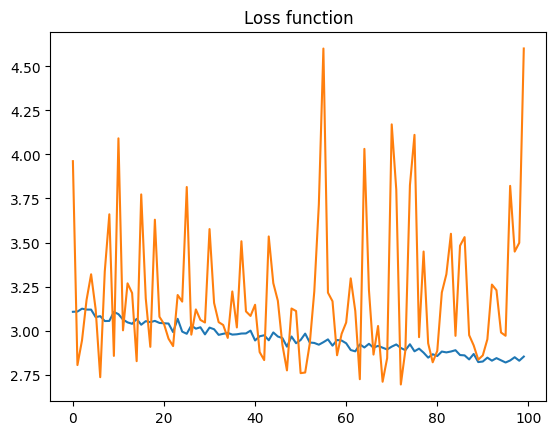

In [15]:
train_loss_hard2, test_loss_hard2 = train_model(model, device, dl_train, dl_test, criterion, optimizer, epochs=100)
torch.save(model.state_dict(), f'models/model_betterNNhard_200epochs.pth') # it will be saved, ...but just in case (rly doesnt make much sense)

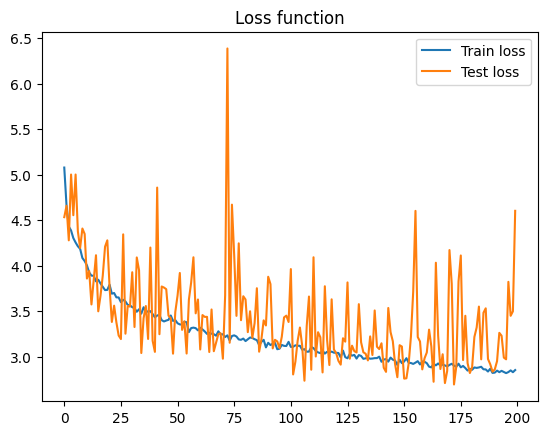

In [16]:
# all train loss
plt.figure()
train_loss_y = np.concatenate((train_loss_hard, train_loss_hard2))
test_loss_y = np.concatenate((test_loss_hard, test_loss_hard2))
x_loss = np.arange(0,len(train_loss_y),1)
plt.plot(x_loss,train_loss_y, label='Train loss') # train loss over all epochs
plt.plot(x_loss,test_loss_y, label='Test loss') # test loss over all epochs
plt.title('Loss function')
plt.legend()
plt.show()

file = open('models/res/loss_betterNNhard.txt', 'w')
file.write('Train loss: \n')
file.write(str(train_loss_y))
file.write('\n')
file.write('Test loss: \n')
file.write(str(test_loss_y))
file.close()